# Turing Target Practice

## Model

In [1]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using PyPlot

using Revise
using MCHMC

In [2]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [3]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [4]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.25)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [5]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [6]:
target = TuringTarget(stat_model);

In [7]:
eps=0.005
L=sqrt(2)
mchmc = Sampler(eps, L, integrator="MN")

Sampler(Settings(Random.MersenneTwister(0), 0.0005, 2000, 1000, 10, "MN"), Hyperparameters{Float64}(0.005, 1.4142135623730951, 0.0, 0.1931833275037836), MCHMC.Minimal_norm)

In [15]:
samples_mchmc = Sample(mchmc, target, 30000);

In [51]:
[sample .^ 2 for sample in samples_mchmc.Ω]

30001-element Vector{Vector{Float64}}:
 [0.0498295069927038, 0.4635203081030951]
 [0.049814790555778546, 0.46926544009929877]
 [0.049805221601196666, 0.47570079621133216]
 [0.04980121394512157, 0.48254721478086476]
 [0.04980062603365642, 0.48951710625385003]
 [0.04980334686928374, 0.49650380761792745]
 [0.049806424295021516, 0.5035302337637583]
 [0.049808759640014494, 0.5106253040561197]
 [0.04980924534840579, 0.5177949992888085]
 [0.049810058293623435, 0.5250126493462515]
 [0.049810429928789375, 0.5322827688858934]
 [0.04980860666166439, 0.5395872423854609]
 [0.04980753692010589, 0.5469522445582928]
 ⋮
 [0.05163919345382433, 0.6682045886244894]
 [0.05161158834305182, 0.6666150618794193]
 [0.05158373694906625, 0.6654372583863499]
 [0.05155594911143754, 0.6667424148879919]
 [0.05152901076070423, 0.6691194664218034]
 [0.05150300310247283, 0.6722605557055981]
 [0.051478964357600576, 0.6765409298384936]
 [0.0514570155202132, 0.6817076380793397]
 [0.05143648123529122, 0.6873738688157276]
 [

## Plotting

In [25]:
Wms_mchmc = [sample[1] for sample in samples_mchmc.Ω]
s8s_mchmc = [sample[2] for sample in samples_mchmc.Ω];

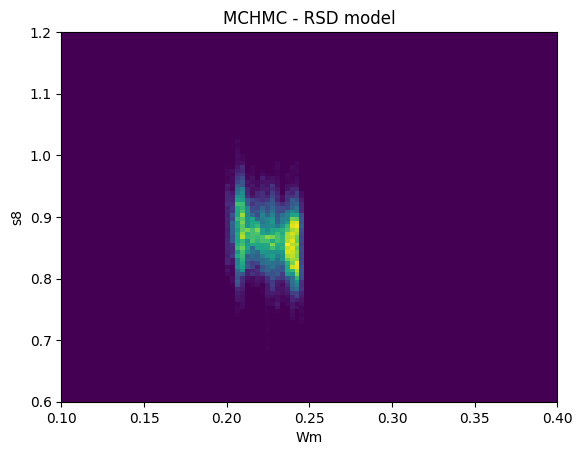

In [26]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

## NUTS

In [12]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling:   1%|▋                                        |  ETA: 0:00:16┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling: 100%|█████████████████████████████

Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 7.49 seconds
Compute duration  = 7.49 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2244    0.0143     0.0001    0.0002   7623.4370    0.9999    ⋯
          σ8    0.8657    0.0385     0.0004    0.0004   7822.1580    1.0002    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [13]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

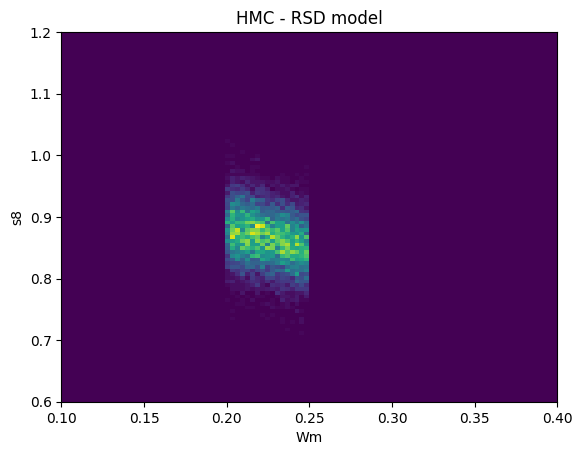

In [14]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");

## Self-tuning

In [55]:
mchmc = Sampler(0.0, 0.0)
println(string("L = ", mchmc.hyperparameters.L, ", eps = ", mchmc.hyperparameters.eps))
# This should start self-tuning    

L = 0.0, eps = 0.0


In [58]:
samples_mchmc = Sample(mchmc, target, 100)

Row,Ω,E
,Any,Any
1,"[0.223225, 0.680823]",-56.6615
2,"[0.223225, 0.680823]",
3,"[NaN, NaN]",
4,"[NaN, NaN]",
5,"[NaN, NaN]",
6,"[NaN, NaN]",
7,"[NaN, NaN]",
8,"[NaN, NaN]",
9,"[NaN, NaN]",
